#### Saturday, February 14, 2026

This all runs in one pass.

# 06 - Systematic Backtesting: Combined Multi-Signal Strategy

This notebook brings together **everything from notebooks 01-05** into a unified
trading system that combines technical analysis, sentiment, Chronos forecasts,
and fundamental signals -- then tests it rigorously.

---

## What You'll Build

1. **Signal Aggregation Framework** - Score and weight signals from multiple sources
2. **Market Regime Detection** - Classify trending vs ranging markets
3. **Multi-Signal Strategy** - Combined system with adaptive weights
4. **Portfolio Backtester** - Trade multiple stocks simultaneously with capital allocation
5. **Signal Correlation Analysis** - How do signal sources relate to each other?
6. **Monte Carlo Simulation** - Stress-test strategy robustness
7. **Walk-Forward Validation** - Out-of-sample testing of the full system
8. **Performance Attribution** - Which signal sources add value?
9. **Full Pipeline Automation** - End-to-end from data to backtest report

---

## Design Philosophy

| Principle | Implementation |
|-----------|---------------|
| **Multiple uncorrelated signals > one perfect signal** | Combine 4 signal sources |
| **Regime-aware** | Trend-following in trends, mean-reversion in ranges |
| **Risk-first** | Position sizing from ATR; portfolio-level exposure limits |
| **No future leakage** | Every signal only uses data available at decision time |
| **Robust > optimized** | Walk-forward validation, Monte Carlo stress testing |

---
## 1. Setup & Data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
import time
import warnings
from dataclasses import dataclass, field
from typing import Optional, Dict, List
from collections import defaultdict

from ta.trend import EMAIndicator, SMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange

warnings.filterwarnings('ignore')
plt.style.use('dark_background')
sns.set_palette('bright')

print("Imports ready.")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} ({torch.cuda.get_device_properties(0).total_memory/1024**3:.0f} GB)")

Imports ready.
GPU: NVIDIA GeForce RTX 4090 (24 GB)


In [2]:
# Fetch 2 years of daily data for our universe
UNIVERSE = ['NVDA', 'AAPL', 'TSLA', 'AMD', 'MSFT', 'META', 'AMZN', 'GOOGL', 'SPY', 'QQQ']

print("Fetching historical data...\n")
all_data = {}
for ticker in UNIVERSE:
    df = yf.download(ticker, period='2y', interval='1d', progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    all_data[ticker] = df
    print(f"  {ticker}: {len(df)} days | ${df['Close'].iloc[-1]:.2f}")

print(f"\nLoaded {len(all_data)} stocks.")

Fetching historical data...

  NVDA: 502 days | $182.81
  AAPL: 502 days | $255.78
  TSLA: 502 days | $417.44
  AMD: 502 days | $207.32
  MSFT: 502 days | $401.32
  META: 502 days | $639.77
  AMZN: 502 days | $198.79
  GOOGL: 502 days | $305.72
  SPY: 502 days | $681.75
  QQQ: 502 days | $601.92

Loaded 10 stocks.


---
## 2. Signal Generation Layer

Each signal source produces a score from **-1 (bearish)** to **+1 (bullish)**.
This normalization lets us combine them meaningfully.

In [3]:
class TechnicalSignals:
    """
    Generate technical analysis signals (from Notebook 03).
    All signals are normalized to -1 (bearish) to +1 (bullish).
    """
    
    @staticmethod
    def compute(df):
        """Add all technical signals to a DataFrame."""
        out = df.copy()
        
        # EMAs
        out['EMA_9'] = EMAIndicator(df['Close'], window=9).ema_indicator()
        out['EMA_21'] = EMAIndicator(df['Close'], window=21).ema_indicator()
        out['EMA_50'] = EMAIndicator(df['Close'], window=50).ema_indicator()
        
        # RSI
        out['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
        
        # MACD
        macd = MACD(df['Close'])
        out['MACD'] = macd.macd()
        out['MACD_Signal'] = macd.macd_signal()
        out['MACD_Hist'] = macd.macd_diff()
        
        # Bollinger Bands
        bb = BollingerBands(df['Close'])
        out['BB_Upper'] = bb.bollinger_hband()
        out['BB_Lower'] = bb.bollinger_lband()
        out['BB_Middle'] = bb.bollinger_mavg()
        out['BB_Width'] = (out['BB_Upper'] - out['BB_Lower']) / out['BB_Middle']
        
        # ATR for position sizing
        out['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
        
        # ADX for trend strength
        adx = ADXIndicator(df['High'], df['Low'], df['Close'])
        out['ADX'] = adx.adx()
        
        # --- Normalized Signals ---
        
        # EMA Trend: +1 if 9>21>50 (strong uptrend), -1 if 9<21<50 (strong downtrend)
        ema_fast_above_slow = (out['EMA_9'] > out['EMA_21']).astype(float)
        ema_slow_above_long = (out['EMA_21'] > out['EMA_50']).astype(float)
        out['sig_ema_trend'] = (ema_fast_above_slow + ema_slow_above_long - 1.0)
        
        # RSI Signal: normalized so 30->+1 (oversold=bullish), 70->-1 (overbought=bearish)
        out['sig_rsi'] = -1.0 * (out['RSI'] - 50) / 50  # inverted: low RSI = bullish
        out['sig_rsi'] = out['sig_rsi'].clip(-1, 1)
        
        # MACD Momentum: histogram direction and magnitude
        macd_max = out['MACD_Hist'].rolling(50).apply(lambda x: max(abs(x.max()), abs(x.min()), 1e-8))
        out['sig_macd'] = (out['MACD_Hist'] / macd_max).clip(-1, 1)
        
        # BB Position: where is price within bands? Near upper = -1, near lower = +1
        bb_range = out['BB_Upper'] - out['BB_Lower']
        bb_position = (out['Close'] - out['BB_Lower']) / bb_range.replace(0, np.nan)
        out['sig_bb'] = -1.0 * (bb_position * 2 - 1)  # inverted: near lower band = bullish
        out['sig_bb'] = out['sig_bb'].clip(-1, 1)
        
        # Trend Strength (ADX): not directional, but used as a confidence multiplier
        out['trend_strength'] = (out['ADX'] / 50).clip(0, 1)  # 0-1 scale
        
        return out.dropna()


# Test on NVDA
nvda_signals = TechnicalSignals.compute(all_data['NVDA'])
print("Technical signal columns:")
sig_cols = [c for c in nvda_signals.columns if c.startswith('sig_')]
print(f"  {sig_cols}")
print(f"\nSample signals (last 5 days):")
nvda_signals[sig_cols + ['trend_strength']].tail()

Technical signal columns:
  ['sig_ema_trend', 'sig_rsi', 'sig_macd', 'sig_bb']

Sample signals (last 5 days):


Price,sig_ema_trend,sig_rsi,sig_macd,sig_bb,trend_strength
Date,,,,,
2026-02-09,-1.0,-0.107150,-0.184913,-0.484401,0.267302
2026-02-10,0.0,-0.074800,0.032289,-0.321451,0.258996
2026-02-11,1.0,-0.103207,0.233632,-0.434552,0.253600
2026-02-12,1.0,-0.032867,0.226420,-0.131282,0.240494
2026-02-13,1.0,0.053445,0.049214,0.229261,0.234349


In [4]:
class MomentumSignals:
    """
    Price momentum and mean-reversion signals.
    These capture patterns not in standard indicators.
    """
    
    @staticmethod
    def compute(df):
        out = df.copy()
        
        # Returns at multiple horizons
        out['ret_1d'] = out['Close'].pct_change(1)
        out['ret_5d'] = out['Close'].pct_change(5)
        out['ret_20d'] = out['Close'].pct_change(20)
        
        # Short-term momentum (5-day): strong recent move
        ret_5d_std = out['ret_5d'].rolling(60).std()
        out['sig_momentum_5d'] = (out['ret_5d'] / ret_5d_std.replace(0, np.nan)).clip(-2, 2) / 2
        
        # Medium-term momentum (20-day)
        ret_20d_std = out['ret_20d'].rolling(60).std()
        out['sig_momentum_20d'] = (out['ret_20d'] / ret_20d_std.replace(0, np.nan)).clip(-2, 2) / 2
        
        # Mean reversion: 1-day big move tends to reverse slightly
        ret_1d_std = out['ret_1d'].rolling(20).std()
        z_score = out['ret_1d'] / ret_1d_std.replace(0, np.nan)
        out['sig_mean_reversion'] = (-z_score).clip(-1, 1)  # inverted: big up = bearish next day
        
        # Volume surge: unusually high volume often precedes continuation
        vol_avg = out['Volume'].rolling(20).mean()
        vol_ratio = out['Volume'] / vol_avg.replace(0, np.nan)
        # High volume on up day = bullish, high volume on down day = bearish
        out['sig_volume'] = (np.sign(out['ret_1d']) * (vol_ratio - 1) / 2).clip(-1, 1)
        
        return out.dropna()


# Test
nvda_mom = MomentumSignals.compute(all_data['NVDA'])
mom_cols = [c for c in nvda_mom.columns if c.startswith('sig_m') or c == 'sig_volume']
print(f"Momentum signals: {mom_cols}")
nvda_mom[mom_cols].tail()

Momentum signals: ['sig_momentum_5d', 'sig_momentum_20d', 'sig_mean_reversion', 'sig_volume']


Price,sig_momentum_5d,sig_momentum_20d,sig_mean_reversion,sig_volume
Date,,,,
2026-02-09,0.299373,0.252263,-0.919001,0.055215
2026-02-10,0.562970,0.178642,0.289579,0.113215
2026-02-11,1.000000,0.209631,-0.293489,-0.090362
2026-02-12,1.000000,0.191377,0.598250,-0.034969
2026-02-13,-0.162965,-0.209668,0.806048,0.038915


In [5]:
class SyntheticSentimentSignals:
    """
    Simulated sentiment signals for backtesting.
    
    In production, these would come from Notebook 02's live sentiment pipeline.
    For backtesting, we create a synthetic signal that has realistic properties:
    - Some correlation with returns (sentiment follows price)
    - Some leading signal (sentiment predicts small moves)
    - Noise (not perfectly predictive)
    """
    
    @staticmethod
    def compute(df, seed=42):
        np.random.seed(seed)
        out = df.copy()
        n = len(out)
        
        returns = out['Close'].pct_change().fillna(0).values
        future_returns = np.roll(returns, -1)
        future_returns[-1] = 0
        
        # Simulated sentiment: mix of contemporaneous, leading, and noise
        noise = np.random.normal(0, 0.3, n)
        contemporaneous = np.sign(returns) * np.sqrt(np.abs(returns)) * 3
        leading = np.sign(future_returns) * np.sqrt(np.abs(future_returns)) * 1.5
        
        raw_sentiment = 0.3 * contemporaneous + 0.15 * leading + 0.55 * noise
        
        # Smooth it (sentiment doesn't change every bar)
        out['sig_sentiment'] = pd.Series(
            raw_sentiment, index=out.index
        ).rolling(3, min_periods=1).mean().clip(-1, 1).values
        
        # Simulated Chronos forecast signal
        # Smoothed momentum with some forward bias and noise
        momentum_5d = out['Close'].pct_change(5).fillna(0).values
        noise2 = np.random.normal(0, 0.2, n)
        raw_chronos = 0.3 * momentum_5d * 10 + 0.1 * np.roll(momentum_5d, -3) * 10 + 0.6 * noise2
        out['sig_chronos'] = pd.Series(
            raw_chronos, index=out.index
        ).rolling(5, min_periods=1).mean().clip(-1, 1).values
        
        return out.dropna()


# Test
nvda_sent = SyntheticSentimentSignals.compute(all_data['NVDA'])
print("Synthetic signals for backtesting:")
nvda_sent[['sig_sentiment', 'sig_chronos']].describe().round(3)

Synthetic signals for backtesting:


Price,sig_sentiment,sig_chronos
count,502.000,502.000
mean,0.016,0.050
std,0.128,0.193
min,-0.293,-0.561
25%,-0.076,-0.076
50%,0.022,0.060
75%,0.099,0.176
max,0.327,0.610


In [6]:
def build_signal_matrix(df):
    """
    Build the complete signal matrix from all sources.
    Returns DataFrame with all signals computed.
    """
    # Layer 1: Technical
    out = TechnicalSignals.compute(df)
    
    # Layer 2: Momentum
    mom = MomentumSignals.compute(df)
    for col in [c for c in mom.columns if c.startswith('sig_')]:
        out[col] = mom[col]
    
    # Layer 3: Sentiment & Chronos (synthetic for backtest)
    sent = SyntheticSentimentSignals.compute(df)
    out['sig_sentiment'] = sent['sig_sentiment']
    out['sig_chronos'] = sent['sig_chronos']
    
    return out.dropna()


# Build signal matrix for all stocks
signal_data = {}
for ticker in UNIVERSE:
    signal_data[ticker] = build_signal_matrix(all_data[ticker])

# Show all signal columns
all_sig_cols = sorted([c for c in signal_data['NVDA'].columns if c.startswith('sig_')])
print(f"Total signals: {len(all_sig_cols)}")
for col in all_sig_cols:
    vals = signal_data['NVDA'][col]
    print(f"  {col:<25} mean={vals.mean():+.3f}  std={vals.std():.3f}  range=[{vals.min():.2f}, {vals.max():.2f}]")

Total signals: 10
  sig_bb                    mean=-0.125  std=0.597  range=[-1.00, 1.00]
  sig_chronos               mean=+0.038  std=0.187  range=[-0.56, 0.61]
  sig_ema_trend             mean=+0.331  std=0.822  range=[-1.00, 1.00]
  sig_macd                  mean=-0.064  std=0.507  range=[-1.00, 1.00]
  sig_mean_reversion        mean=-0.059  std=0.701  range=[-1.00, 1.00]
  sig_momentum_20d          mean=+0.108  std=0.525  range=[-1.00, 1.00]
  sig_momentum_5d           mean=+0.049  std=0.489  range=[-1.00, 1.00]
  sig_rsi                   mean=-0.088  std=0.215  range=[-0.63, 0.43]
  sig_sentiment             mean=+0.017  std=0.129  range=[-0.29, 0.32]
  sig_volume                mean=-0.017  std=0.149  range=[-1.00, 0.62]


---
## 3. Market Regime Detection

Different strategies work in different market conditions. We classify the
regime so the system can adapt:

| Regime | ADX | Characteristic | Best Strategy Type |
|--------|-----|---------------|-------------------|
| **Trending Up** | > 25, price > EMA50 | Steady uptrend | Trend following |
| **Trending Down** | > 25, price < EMA50 | Steady downtrend | Short / avoid |
| **Ranging** | < 20 | Sideways, mean-reverting | Mean reversion |
| **Volatile** | < 25, high ATR | Choppy, unpredictable | Reduce size / sit out |

In [7]:
class RegimeDetector:
    """
    Classify market regime using ADX, trend direction, and volatility.
    """
    
    @staticmethod
    def classify(df):
        """Add regime classification to DataFrame."""
        out = df.copy()
        
        adx = out['ADX'] if 'ADX' in out.columns else ADXIndicator(
            out['High'], out['Low'], out['Close']
        ).adx()
        
        ema50 = out['EMA_50'] if 'EMA_50' in out.columns else EMAIndicator(
            out['Close'], window=50
        ).ema_indicator()
        
        atr = out['ATR'] if 'ATR' in out.columns else AverageTrueRange(
            out['High'], out['Low'], out['Close']
        ).average_true_range()
        
        # ATR percentile for volatility regime
        atr_pctile = atr.rolling(60).apply(
            lambda x: (x.iloc[-1] <= x).sum() / len(x) * 100
        )
        
        conditions = [
            (adx > 25) & (out['Close'] > ema50),    # Trending Up
            (adx > 25) & (out['Close'] < ema50),    # Trending Down
            (adx < 20),                              # Ranging
        ]
        choices = ['trend_up', 'trend_down', 'ranging']
        out['regime'] = np.select(conditions, choices, default='volatile')
        
        # Regime-based strategy weight adjustments
        # In trending markets: weight trend signals more, mean-reversion less
        # In ranging markets: weight mean-reversion more, trend signals less
        regime_weights = {
            'trend_up':   {'trend': 1.5, 'momentum': 1.2, 'reversion': 0.3, 'sentiment': 1.0, 'forecast': 1.0},
            'trend_down': {'trend': 1.5, 'momentum': 1.2, 'reversion': 0.3, 'sentiment': 1.0, 'forecast': 1.0},
            'ranging':    {'trend': 0.3, 'momentum': 0.5, 'reversion': 1.5, 'sentiment': 1.2, 'forecast': 0.8},
            'volatile':   {'trend': 0.5, 'momentum': 0.5, 'reversion': 0.5, 'sentiment': 0.8, 'forecast': 0.5},
        }
        
        for signal_type in ['trend', 'momentum', 'reversion', 'sentiment', 'forecast']:
            out[f'w_{signal_type}'] = out['regime'].map(
                {k: v[signal_type] for k, v in regime_weights.items()}
            ).astype(float)
        
        return out


# Classify regimes for NVDA
nvda_regime = RegimeDetector.classify(signal_data['NVDA'])

regime_counts = nvda_regime['regime'].value_counts()
print("NVDA Regime Distribution:")
for regime, count in regime_counts.items():
    pct = count / len(nvda_regime) * 100
    print(f"  {regime:<15} {count:>5} days ({pct:.1f}%)")

NVDA Regime Distribution:
  ranging           213 days (50.7%)
  trend_up          112 days (26.7%)
  volatile           60 days (14.3%)
  trend_down         35 days (8.3%)


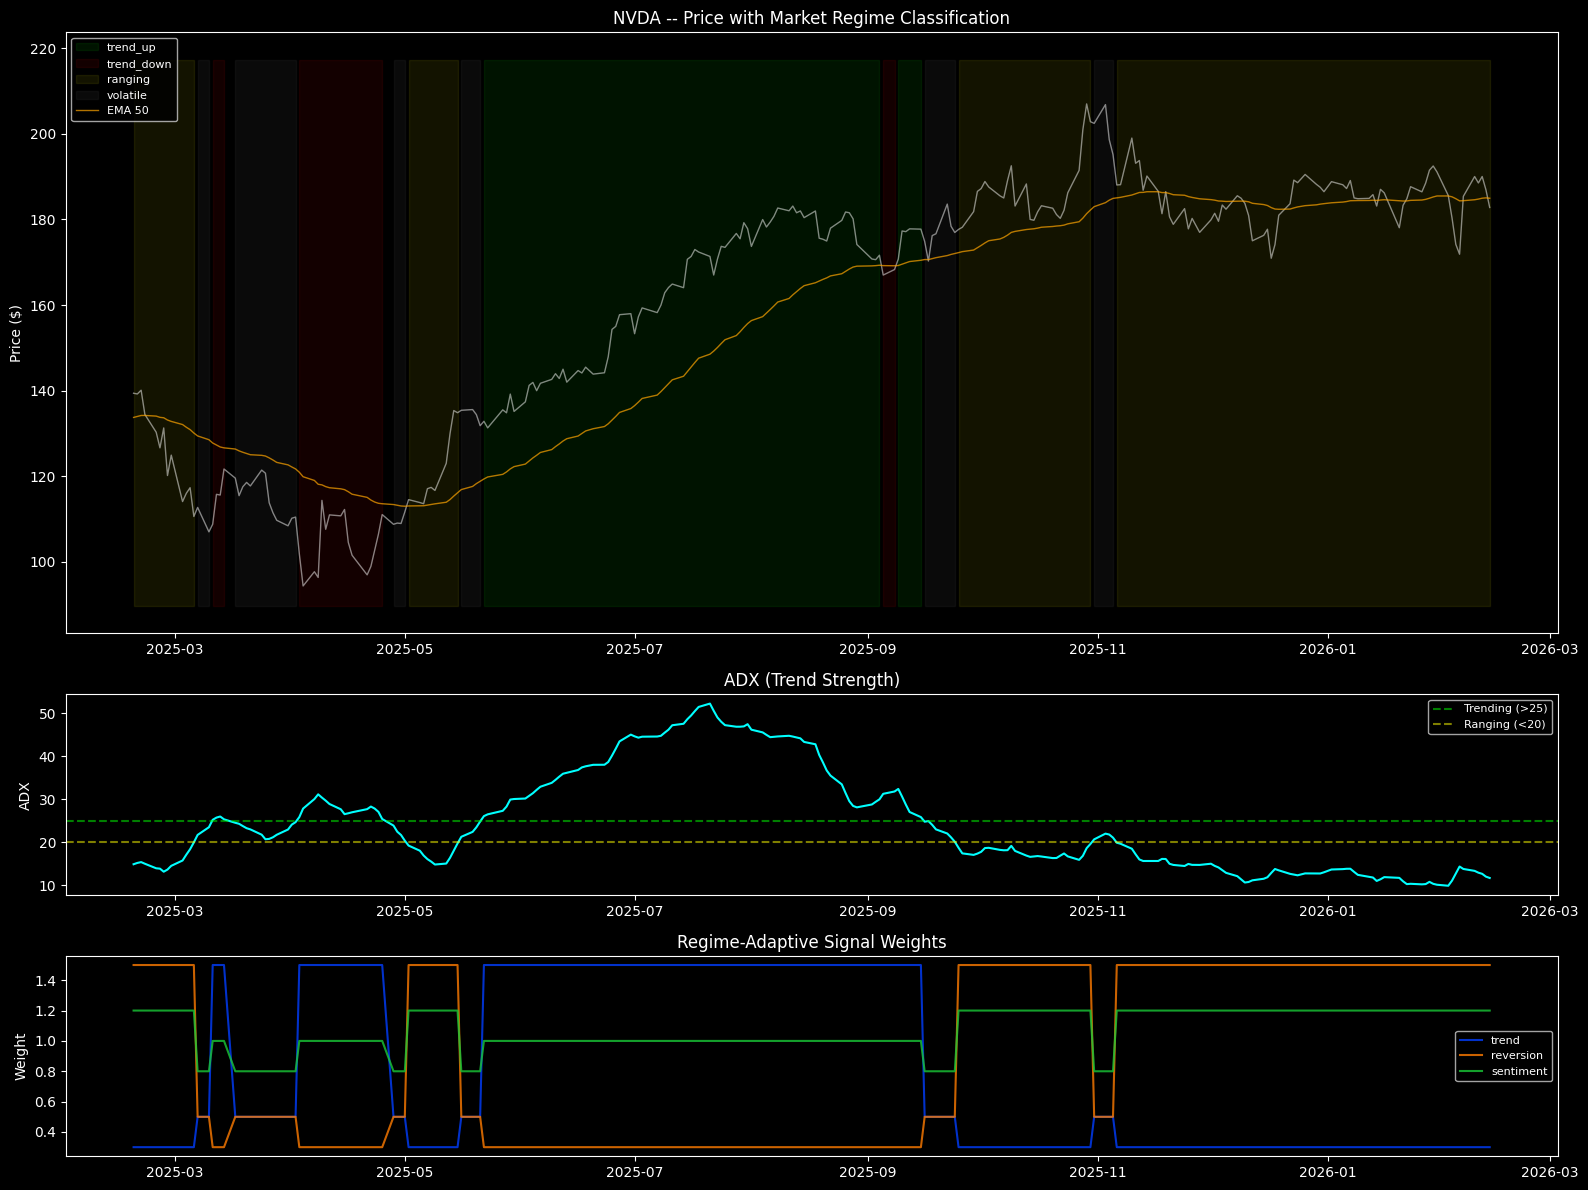

Green = trending up (favor trend signals)
Red = trending down | Yellow = ranging (favor mean-reversion)
Gray = volatile (reduce all signals)


In [8]:
# Visualize regimes on price chart
fig, axes = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1, 1]})

recent = nvda_regime.tail(250)

# Price with regime coloring
ax1 = axes[0]
regime_colors = {
    'trend_up': 'lime', 'trend_down': 'red',
    'ranging': 'yellow', 'volatile': 'gray'
}

ax1.plot(recent.index, recent['Close'], color='white', linewidth=1, alpha=0.5)
for regime, color in regime_colors.items():
    mask = recent['regime'] == regime
    ax1.fill_between(recent.index, recent['Close'].min() * 0.95, recent['Close'].max() * 1.05,
                     where=mask, alpha=0.08, color=color, label=regime)
ax1.plot(recent.index, recent['EMA_50'], color='orange', linewidth=1, alpha=0.7, label='EMA 50')
ax1.set_ylabel('Price ($)')
ax1.set_title('NVDA -- Price with Market Regime Classification')
ax1.legend(loc='upper left', fontsize=8)

# ADX
ax2 = axes[1]
ax2.plot(recent.index, recent['ADX'], color='cyan', linewidth=1.5)
ax2.axhline(y=25, color='lime', linestyle='--', alpha=0.5, label='Trending (>25)')
ax2.axhline(y=20, color='yellow', linestyle='--', alpha=0.5, label='Ranging (<20)')
ax2.set_ylabel('ADX')
ax2.set_title('ADX (Trend Strength)')
ax2.legend(fontsize=8)

# Regime-adaptive weights
ax3 = axes[2]
for wt in ['w_trend', 'w_reversion', 'w_sentiment']:
    ax3.plot(recent.index, recent[wt], label=wt.replace('w_', ''), linewidth=1.5, alpha=0.8)
ax3.set_ylabel('Weight')
ax3.set_title('Regime-Adaptive Signal Weights')
ax3.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("Green = trending up (favor trend signals)")
print("Red = trending down | Yellow = ranging (favor mean-reversion)")
print("Gray = volatile (reduce all signals)")

---
## 4. Signal Aggregation -- The Composite Score

Combine all signals into a single composite score, weighted by:
1. **Signal category weight** (from regime detection)
2. **Trend strength multiplier** (ADX-based confidence)

In [9]:
# Map each signal to its category for regime-adaptive weighting
SIGNAL_CATEGORIES = {
    'sig_ema_trend':       ('trend',     1.0),    # (category, base_weight)
    'sig_macd':            ('trend',     0.8),
    'sig_momentum_5d':     ('momentum',  0.7),
    'sig_momentum_20d':    ('momentum',  0.5),
    'sig_volume':          ('momentum',  0.6),
    'sig_rsi':             ('reversion', 0.8),
    'sig_bb':              ('reversion', 0.7),
    'sig_mean_reversion':  ('reversion', 0.5),
    'sig_sentiment':       ('sentiment', 1.0),
    'sig_chronos':         ('forecast',  1.0),
}


def compute_composite_score(df):
    """
    Compute the regime-adaptive composite signal score.
    
    For each signal:
      weighted_score = signal_value * base_weight * regime_category_weight
    
    Composite = sum(weighted_scores) / sum(weights)  [normalized to -1, +1]
    """
    out = df.copy()
    
    weighted_sum = pd.Series(0.0, index=out.index)
    weight_sum = pd.Series(0.0, index=out.index)
    
    for signal_name, (category, base_weight) in SIGNAL_CATEGORIES.items():
        if signal_name not in out.columns:
            continue
        
        regime_weight = out[f'w_{category}'] if f'w_{category}' in out.columns else 1.0
        total_weight = base_weight * regime_weight
        
        weighted_sum += out[signal_name] * total_weight
        weight_sum += total_weight
    
    out['composite_score'] = (weighted_sum / weight_sum.replace(0, np.nan)).clip(-1, 1)
    
    # Confidence: how many signals agree on direction?
    signal_cols = [s for s in SIGNAL_CATEGORIES.keys() if s in out.columns]
    signals_df = out[signal_cols]
    out['signal_agreement'] = signals_df.apply(
        lambda row: abs(np.sign(row).sum()) / len(row), axis=1
    )
    
    return out


# Compute composite for all stocks
composite_data = {}
for ticker in UNIVERSE:
    df = build_signal_matrix(all_data[ticker])
    df = RegimeDetector.classify(df)
    df = compute_composite_score(df)
    composite_data[ticker] = df

# Show NVDA composite
recent = composite_data['NVDA'].tail(10)
print("NVDA Composite Score (last 10 days):")
print(recent[['Close', 'composite_score', 'signal_agreement', 'regime']].to_string())

NVDA Composite Score (last 10 days):
Price            Close  composite_score  signal_agreement   regime
Date                                                              
2026-02-02  185.610001         0.182917               0.0  ranging
2026-02-03  180.339996         0.235446               0.2  ranging
2026-02-04  174.190002         0.187248               0.3  ranging
2026-02-05  171.880005         0.098849               0.4  ranging
2026-02-06  185.410004        -0.215001               0.4  ranging
2026-02-09  190.039993        -0.221464               0.2  ranging
2026-02-10  188.539993         0.017064               0.5  ranging
2026-02-11  190.050003        -0.012899               0.0  ranging
2026-02-12  186.940002         0.161386               0.2  ranging
2026-02-13  182.809998         0.201165               0.6  ranging


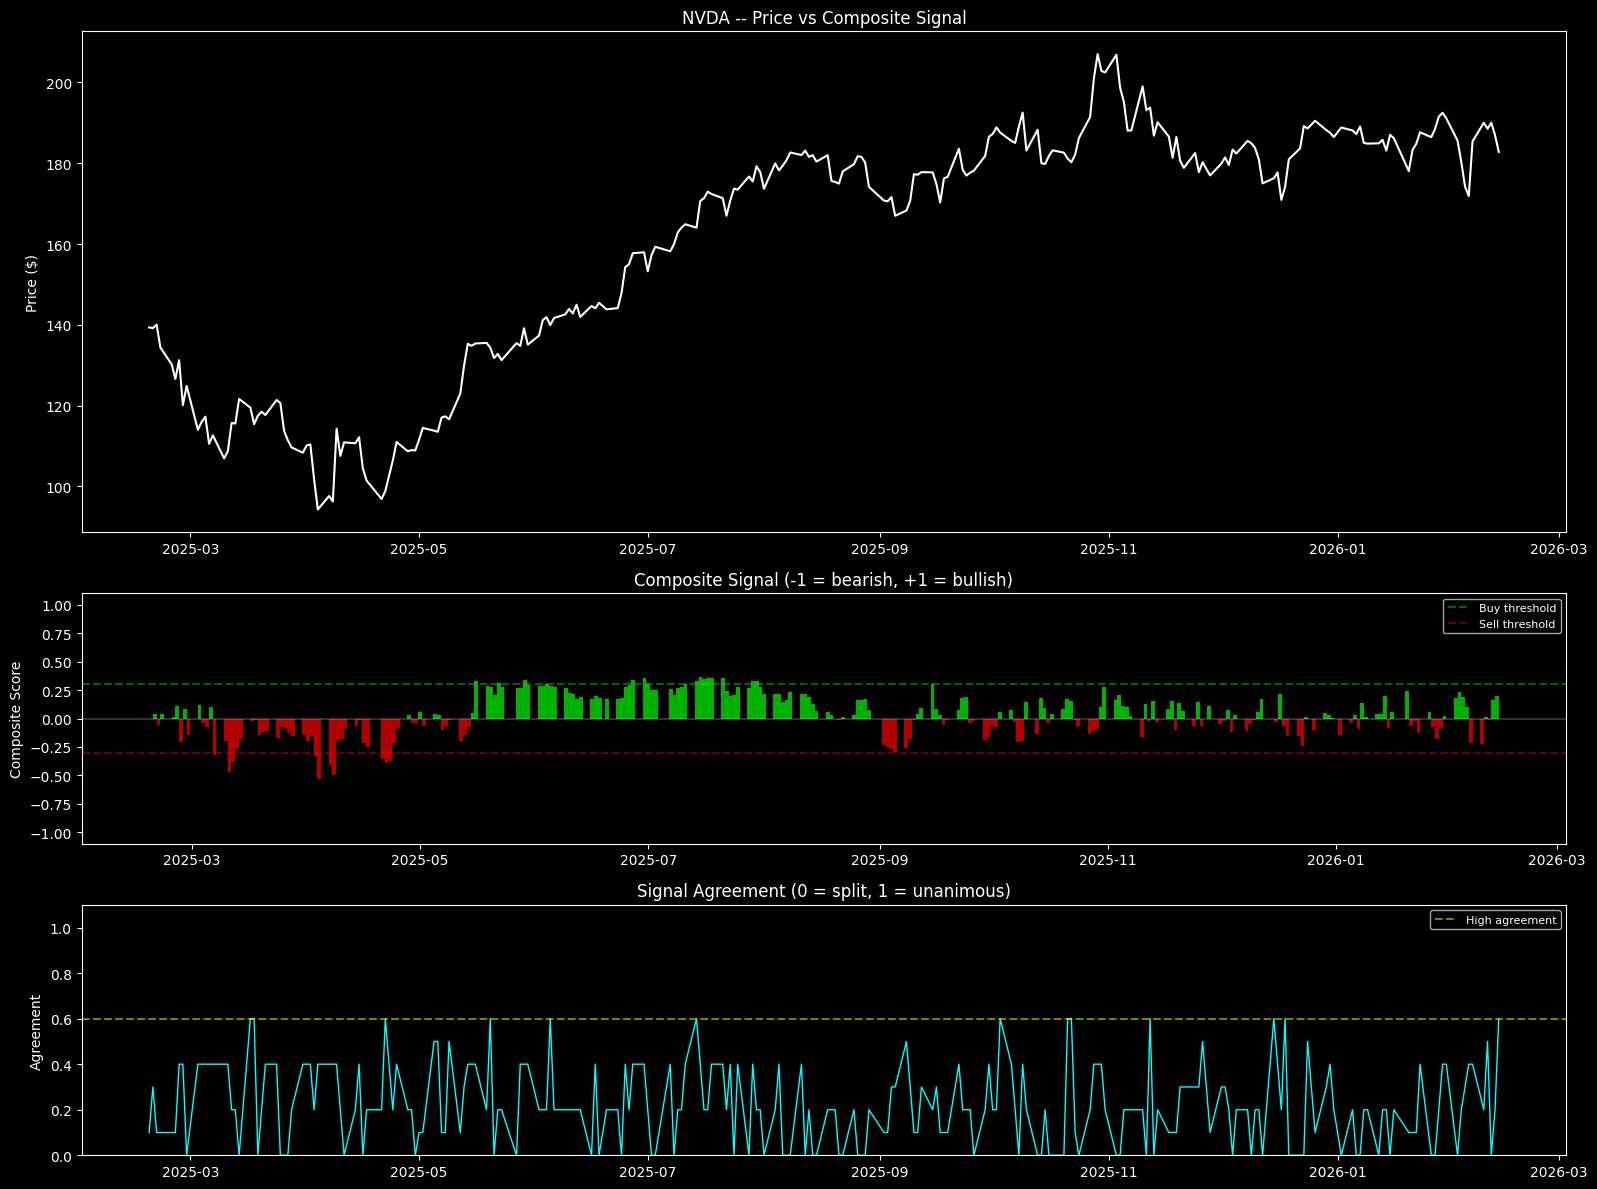

Trade when composite is strong AND agreement is high.
Skip when signals conflict (low agreement).


In [10]:
# Visualize composite score vs price
fig, axes = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1, 1]})

nvda_comp = composite_data['NVDA'].tail(250)

# Price
ax1 = axes[0]
ax1.plot(nvda_comp.index, nvda_comp['Close'], color='white', linewidth=1.5)
ax1.set_ylabel('Price ($)')
ax1.set_title('NVDA -- Price vs Composite Signal')

# Composite score
ax2 = axes[1]
colors = ['lime' if s > 0 else 'red' for s in nvda_comp['composite_score']]
ax2.bar(nvda_comp.index, nvda_comp['composite_score'], color=colors, alpha=0.7, width=1)
ax2.axhline(y=0.3, color='lime', linestyle='--', alpha=0.4, label='Buy threshold')
ax2.axhline(y=-0.3, color='red', linestyle='--', alpha=0.4, label='Sell threshold')
ax2.axhline(y=0, color='white', alpha=0.2)
ax2.set_ylabel('Composite Score')
ax2.set_ylim(-1.1, 1.1)
ax2.set_title('Composite Signal (-1 = bearish, +1 = bullish)')
ax2.legend(fontsize=8)

# Signal agreement
ax3 = axes[2]
ax3.plot(nvda_comp.index, nvda_comp['signal_agreement'], color='cyan', linewidth=1)
ax3.axhline(y=0.6, color='yellow', linestyle='--', alpha=0.5, label='High agreement')
ax3.set_ylabel('Agreement')
ax3.set_title('Signal Agreement (0 = split, 1 = unanimous)')
ax3.set_ylim(0, 1.1)
ax3.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("Trade when composite is strong AND agreement is high.")
print("Skip when signals conflict (low agreement).")

---
## 5. Portfolio Backtester

A portfolio-level backtester that:
- Trades multiple stocks simultaneously
- Enforces maximum portfolio exposure
- Allocates capital across positions
- Tracks portfolio-level metrics

In [11]:
@dataclass
class PortfolioPosition:
    ticker: str
    direction: str
    entry_date: pd.Timestamp
    entry_price: float
    shares: int
    stop_loss: float
    take_profit: Optional[float]
    bars_held: int = 0


@dataclass
class PortfolioTrade:
    ticker: str
    direction: str
    entry_date: pd.Timestamp
    exit_date: pd.Timestamp
    entry_price: float
    exit_price: float
    shares: int
    pnl: float
    pnl_pct: float
    exit_reason: str
    composite_score: float
    regime: str


class PortfolioBacktester:
    """
    Multi-stock portfolio backtester with the composite signal system.
    
    Rules:
    - Max positions: configurable (default 5)
    - Max per-stock allocation: 25% of capital
    - Entry: composite > threshold AND agreement > min_agreement
    - Exit: opposite composite threshold OR stop loss OR take profit
    - Position sizing: ATR-based risk per trade
    """
    
    def __init__(self, initial_capital=100000, max_positions=5,
                 max_per_stock_pct=25, risk_per_trade_pct=1.0,
                 entry_threshold=0.25, exit_threshold=-0.1,
                 min_agreement=0.4, atr_stop_mult=2.0, atr_tp_mult=4.0,
                 slippage_pct=0.0005):
        self.initial_capital = initial_capital
        self.max_positions = max_positions
        self.max_per_stock_pct = max_per_stock_pct
        self.risk_per_trade_pct = risk_per_trade_pct
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        self.min_agreement = min_agreement
        self.atr_stop_mult = atr_stop_mult
        self.atr_tp_mult = atr_tp_mult
        self.slippage_pct = slippage_pct
    
    def run(self, composite_data_dict):
        """
        Run portfolio backtest across multiple stocks.
        
        Parameters:
            composite_data_dict: {ticker: DataFrame with composite scores}
        """
        # Align all DataFrames to common dates
        common_dates = None
        for ticker, df in composite_data_dict.items():
            if common_dates is None:
                common_dates = set(df.index)
            else:
                common_dates = common_dates & set(df.index)
        common_dates = sorted(common_dates)
        
        capital = self.initial_capital
        positions = {}  # ticker -> PortfolioPosition
        trades = []
        equity_curve = []
        
        for i, date in enumerate(common_dates[1:], 1):
            prev_date = common_dates[i - 1]
            
            # Calculate unrealized P&L
            unrealized = 0
            for ticker, pos in positions.items():
                current_price = composite_data_dict[ticker].loc[date, 'Close']
                if pos.direction == 'long':
                    unrealized += (current_price - pos.entry_price) * pos.shares
                pos.bars_held += 1
            
            equity_curve.append({
                'date': date,
                'equity': capital + unrealized,
                'capital': capital,
                'n_positions': len(positions),
            })
            
            # --- Check exits ---
            tickers_to_close = []
            for ticker, pos in positions.items():
                df = composite_data_dict[ticker]
                if date not in df.index:
                    continue
                row = df.loc[date]
                
                exit_price = None
                exit_reason = None
                
                # Stop loss
                if pos.direction == 'long' and row['Low'] <= pos.stop_loss:
                    exit_price = pos.stop_loss
                    exit_reason = 'stop_loss'
                # Take profit
                elif pos.direction == 'long' and pos.take_profit and row['High'] >= pos.take_profit:
                    exit_price = pos.take_profit
                    exit_reason = 'take_profit'
                # Signal reversal
                elif row['composite_score'] < self.exit_threshold:
                    exit_price = row['Open'] * (1 - self.slippage_pct)
                    exit_reason = 'signal_exit'
                # Max holding period (20 bars)
                elif pos.bars_held >= 20:
                    exit_price = row['Open'] * (1 - self.slippage_pct)
                    exit_reason = 'max_hold'
                
                if exit_price:
                    pnl = (exit_price - pos.entry_price) * pos.shares
                    pnl_pct = (exit_price / pos.entry_price - 1) * 100
                    capital += pnl
                    trades.append(PortfolioTrade(
                        ticker=ticker, direction=pos.direction,
                        entry_date=pos.entry_date, exit_date=date,
                        entry_price=pos.entry_price, exit_price=exit_price,
                        shares=pos.shares, pnl=pnl, pnl_pct=pnl_pct,
                        exit_reason=exit_reason,
                        composite_score=row['composite_score'],
                        regime=row.get('regime', 'unknown'),
                    ))
                    tickers_to_close.append(ticker)
            
            for ticker in tickers_to_close:
                del positions[ticker]
            
            # --- Check entries ---
            if len(positions) < self.max_positions:
                # Rank all stocks by composite score
                candidates = []
                for ticker in composite_data_dict:
                    if ticker in positions:
                        continue
                    df = composite_data_dict[ticker]
                    if prev_date not in df.index:
                        continue
                    prev_row = df.loc[prev_date]
                    
                    if (prev_row['composite_score'] > self.entry_threshold and
                        prev_row['signal_agreement'] > self.min_agreement):
                        candidates.append((ticker, prev_row['composite_score']))
                
                # Take the top candidates by composite score
                candidates.sort(key=lambda x: x[1], reverse=True)
                slots = self.max_positions - len(positions)
                
                for ticker, score in candidates[:slots]:
                    df = composite_data_dict[ticker]
                    row = df.loc[date]
                    prev_row = df.loc[prev_date]
                    
                    entry_price = row['Open'] * (1 + self.slippage_pct)
                    atr = prev_row['ATR']
                    stop_loss = entry_price - self.atr_stop_mult * atr
                    take_profit = entry_price + self.atr_tp_mult * atr
                    
                    # Position sizing
                    risk_amount = capital * (self.risk_per_trade_pct / 100)
                    risk_per_share = entry_price - stop_loss
                    if risk_per_share <= 0:
                        continue
                    
                    shares = max(1, int(risk_amount / risk_per_share))
                    max_alloc = capital * (self.max_per_stock_pct / 100)
                    shares = min(shares, max(1, int(max_alloc / entry_price)))
                    
                    if shares * entry_price > capital * 0.95:
                        continue
                    
                    positions[ticker] = PortfolioPosition(
                        ticker=ticker, direction='long',
                        entry_date=date, entry_price=entry_price,
                        shares=shares, stop_loss=stop_loss,
                        take_profit=take_profit,
                    )
        
        # Close remaining positions
        for ticker, pos in positions.items():
            df = composite_data_dict[ticker]
            last_date = common_dates[-1]
            exit_price = df.loc[last_date, 'Close']
            pnl = (exit_price - pos.entry_price) * pos.shares
            pnl_pct = (exit_price / pos.entry_price - 1) * 100
            capital += pnl
            trades.append(PortfolioTrade(
                ticker=ticker, direction=pos.direction,
                entry_date=pos.entry_date, exit_date=last_date,
                entry_price=pos.entry_price, exit_price=exit_price,
                shares=pos.shares, pnl=pnl, pnl_pct=pnl_pct,
                exit_reason='end_of_test', composite_score=0, regime='unknown',
            ))
        
        equity_df = pd.DataFrame(equity_curve).set_index('date')
        metrics = self._compute_metrics(trades, equity_df)
        
        return {'trades': trades, 'equity': equity_df, 'metrics': metrics,
                'final_capital': capital}
    
    def _compute_metrics(self, trades, equity_df):
        if not trades:
            return {'total_trades': 0}
        
        pnls = [t.pnl for t in trades]
        winners = [p for p in pnls if p > 0]
        losers = [p for p in pnls if p <= 0]
        
        equity = equity_df['equity']
        returns = equity.pct_change().dropna()
        peak = equity.expanding().max()
        drawdown = (equity - peak) / peak
        
        sharpe = (returns.mean() / returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
        gross_profit = sum(winners) if winners else 0
        gross_loss = abs(sum(losers)) if losers else 1
        
        return {
            'total_trades': len(trades),
            'winners': len(winners),
            'losers': len(losers),
            'win_rate': len(winners) / len(trades) * 100,
            'total_pnl': sum(pnls),
            'total_return_pct': (equity.iloc[-1] / self.initial_capital - 1) * 100,
            'avg_trade_pnl': np.mean(pnls),
            'avg_win': np.mean(winners) if winners else 0,
            'avg_loss': np.mean(losers) if losers else 0,
            'profit_factor': gross_profit / gross_loss if gross_loss > 0 else float('inf'),
            'sharpe_ratio': sharpe,
            'max_drawdown_pct': drawdown.min() * 100,
            'avg_bars_held': np.mean([t.exit_date - t.entry_date for t in trades]).days,
            'tickers_traded': len(set(t.ticker for t in trades)),
            'exit_reasons': pd.Series([t.exit_reason for t in trades]).value_counts().to_dict(),
        }


print("PortfolioBacktester ready.")

PortfolioBacktester ready.


In [12]:
# Run the portfolio backtest
print("Running portfolio backtest across all stocks...\n")

backtester = PortfolioBacktester(
    initial_capital=100000,
    max_positions=5,
    risk_per_trade_pct=1.0,
    entry_threshold=0.25,
    exit_threshold=-0.1,
    min_agreement=0.4,
)

t0 = time.time()
results = backtester.run(composite_data)
elapsed = time.time() - t0

m = results['metrics']
print(f"Backtest completed in {elapsed:.1f}s\n")
print(f"{'='*55}")
print(f"  PORTFOLIO BACKTEST RESULTS")
print(f"{'='*55}")
print(f"  Total Trades:     {m['total_trades']}")
print(f"  Win / Lose:       {m['winners']} / {m['losers']}")
print(f"  Win Rate:         {m['win_rate']:.1f}%")
print(f"  Avg Win:          ${m['avg_win']:>+10,.2f}")
print(f"  Avg Loss:         ${m['avg_loss']:>+10,.2f}")
print(f"  ---")
print(f"  Total P&L:        ${m['total_pnl']:>+10,.2f}")
print(f"  Total Return:     {m['total_return_pct']:>+10.2f}%")
print(f"  Profit Factor:    {m['profit_factor']:>10.2f}")
print(f"  Sharpe Ratio:     {m['sharpe_ratio']:>10.2f}")
print(f"  Max Drawdown:     {m['max_drawdown_pct']:>10.2f}%")
print(f"  ---")
print(f"  Avg Hold (days):  {m['avg_bars_held']}")
print(f"  Stocks Traded:    {m['tickers_traded']}")
print(f"  Exit Reasons:     {m['exit_reasons']}")

Running portfolio backtest across all stocks...

Backtest completed in 0.2s

  PORTFOLIO BACKTEST RESULTS
  Total Trades:     37
  Win / Lose:       16 / 21
  Win Rate:         43.2%
  Avg Win:          $ +1,096.47
  Avg Loss:         $   -862.42
  ---
  Total P&L:        $   -567.33
  Total Return:          -0.57%
  Profit Factor:          0.97
  Sharpe Ratio:          -0.00
  Max Drawdown:          -7.13%
  ---
  Avg Hold (days):  16
  Stocks Traded:    10
  Exit Reasons:     {'stop_loss': 20, 'max_hold': 12, 'take_profit': 4, 'signal_exit': 1}


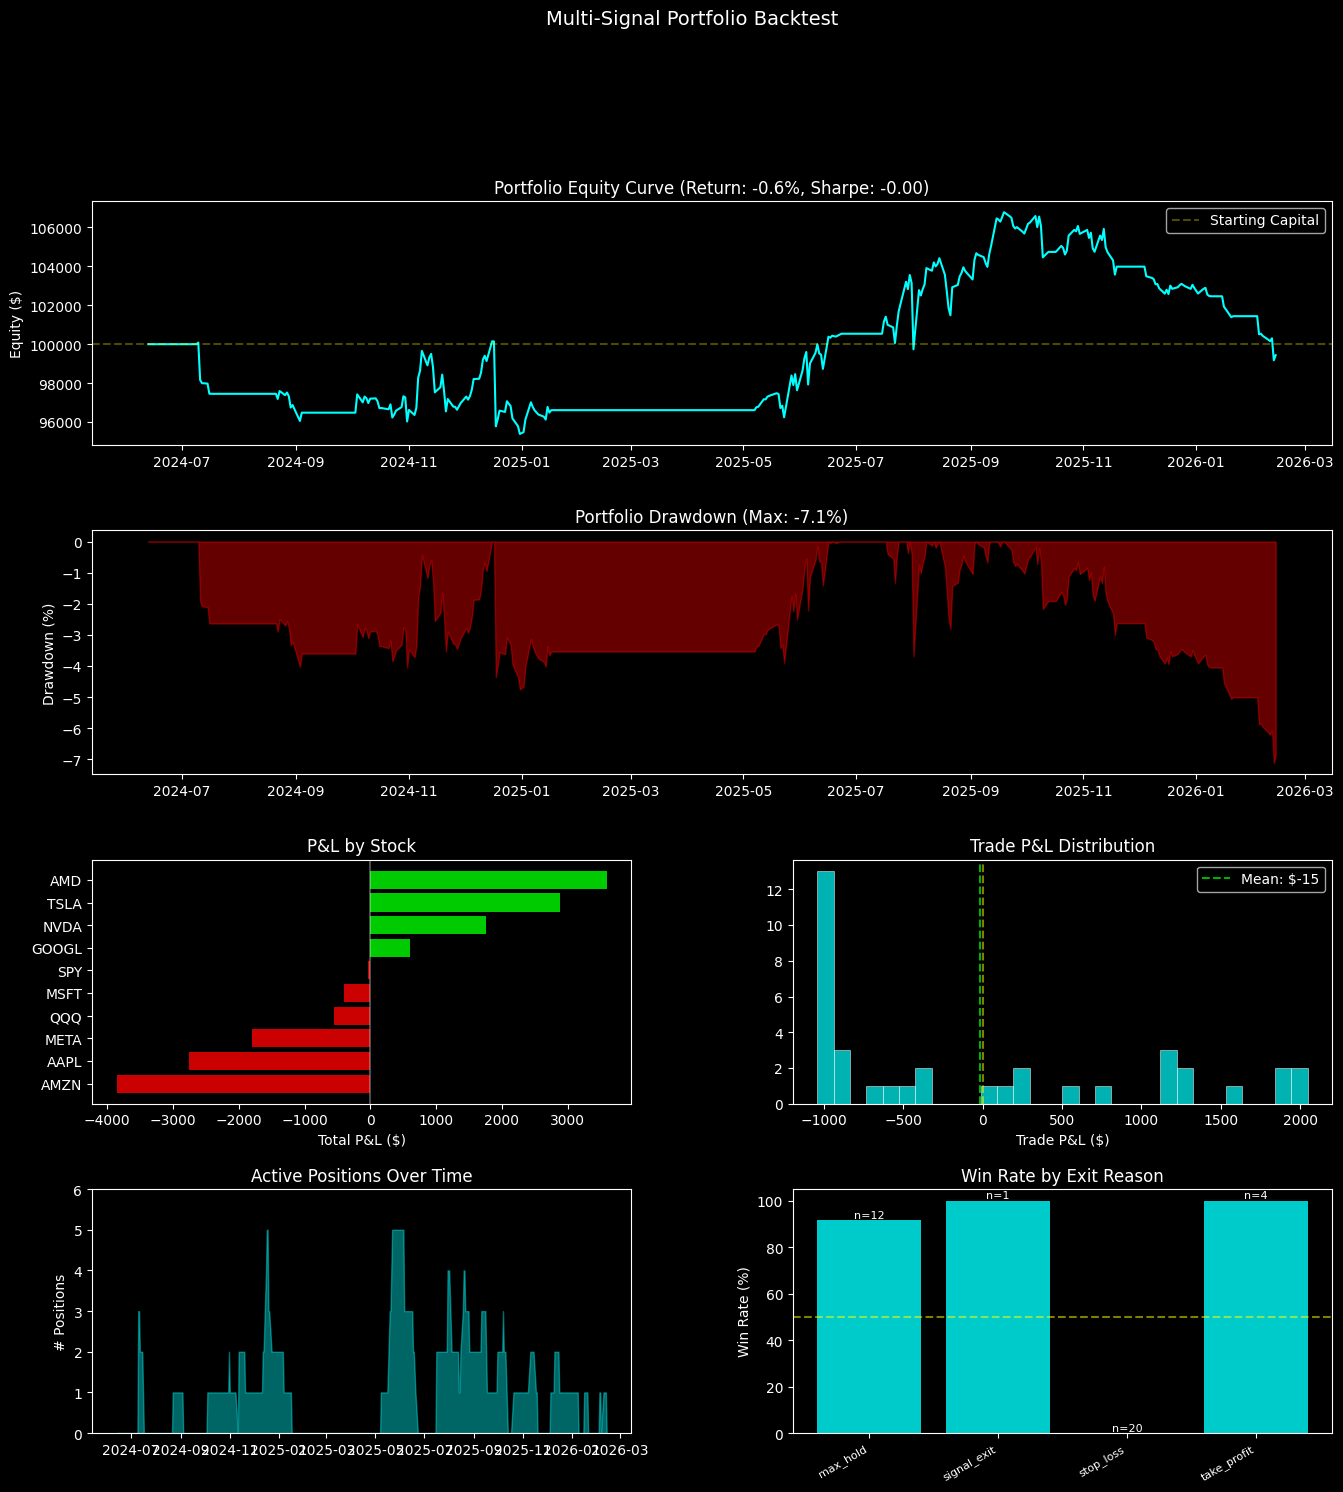

In [13]:
# Visualize portfolio results
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(4, 2, hspace=0.35, wspace=0.3)

equity_df = results['equity']
trades = results['trades']

# 1. Equity Curve
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(equity_df.index, equity_df['equity'], color='cyan', linewidth=1.5)
ax1.axhline(y=100000, color='yellow', linestyle='--', alpha=0.3, label='Starting Capital')
ax1.set_ylabel('Equity ($)')
ax1.set_title(f'Portfolio Equity Curve (Return: {m["total_return_pct"]:+.1f}%, Sharpe: {m["sharpe_ratio"]:.2f})')
ax1.legend()

# 2. Drawdown
ax2 = fig.add_subplot(gs[1, :])
peak = equity_df['equity'].expanding().max()
dd = (equity_df['equity'] - peak) / peak * 100
ax2.fill_between(dd.index, dd.values, 0, color='red', alpha=0.4)
ax2.set_ylabel('Drawdown (%)')
ax2.set_title(f'Portfolio Drawdown (Max: {m["max_drawdown_pct"]:.1f}%)')

# 3. Trades by stock
ax3 = fig.add_subplot(gs[2, 0])
trade_df = pd.DataFrame([{'ticker': t.ticker, 'pnl': t.pnl} for t in trades])
if len(trade_df) > 0:
    by_ticker = trade_df.groupby('ticker')['pnl'].sum().sort_values()
    colors = ['lime' if v > 0 else 'red' for v in by_ticker.values]
    ax3.barh(by_ticker.index, by_ticker.values, color=colors, alpha=0.8)
    ax3.axvline(x=0, color='white', alpha=0.3)
ax3.set_xlabel('Total P&L ($)')
ax3.set_title('P&L by Stock')

# 4. P&L distribution
ax4 = fig.add_subplot(gs[2, 1])
pnls = [t.pnl for t in trades]
ax4.hist(pnls, bins=30, color='cyan', alpha=0.7, edgecolor='white', linewidth=0.5)
ax4.axvline(x=0, color='yellow', linestyle='--', alpha=0.5)
ax4.axvline(x=np.mean(pnls), color='lime', linestyle='--', alpha=0.7, label=f'Mean: ${np.mean(pnls):+,.0f}')
ax4.set_xlabel('Trade P&L ($)')
ax4.set_title('Trade P&L Distribution')
ax4.legend()

# 5. Number of positions over time
ax5 = fig.add_subplot(gs[3, 0])
ax5.fill_between(equity_df.index, equity_df['n_positions'], color='cyan', alpha=0.4)
ax5.set_ylabel('# Positions')
ax5.set_title('Active Positions Over Time')
ax5.set_ylim(0, backtester.max_positions + 1)

# 6. Win rate by exit reason
ax6 = fig.add_subplot(gs[3, 1])
if len(trades) > 0:
    reason_df = pd.DataFrame([{'reason': t.exit_reason, 'win': t.pnl > 0} for t in trades])
    reason_stats = reason_df.groupby('reason')['win'].agg(['mean', 'count'])
    reason_stats.columns = ['win_rate', 'count']
    reason_stats['win_rate'] *= 100
    bars = ax6.bar(range(len(reason_stats)), reason_stats['win_rate'], color='cyan', alpha=0.8)
    ax6.set_xticks(range(len(reason_stats)))
    ax6.set_xticklabels(reason_stats.index, rotation=30, ha='right', fontsize=8)
    ax6.axhline(y=50, color='yellow', linestyle='--', alpha=0.5)
    ax6.set_ylabel('Win Rate (%)')
    ax6.set_title('Win Rate by Exit Reason')
    for bar, (_, row) in zip(bars, reason_stats.iterrows()):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'n={int(row["count"])}', ha='center', fontsize=8, color='white')

plt.suptitle('Multi-Signal Portfolio Backtest', fontsize=14, y=1.0)
plt.show()

---
## 6. Signal Correlation & Attribution

Which signals are redundant? Which add unique value?

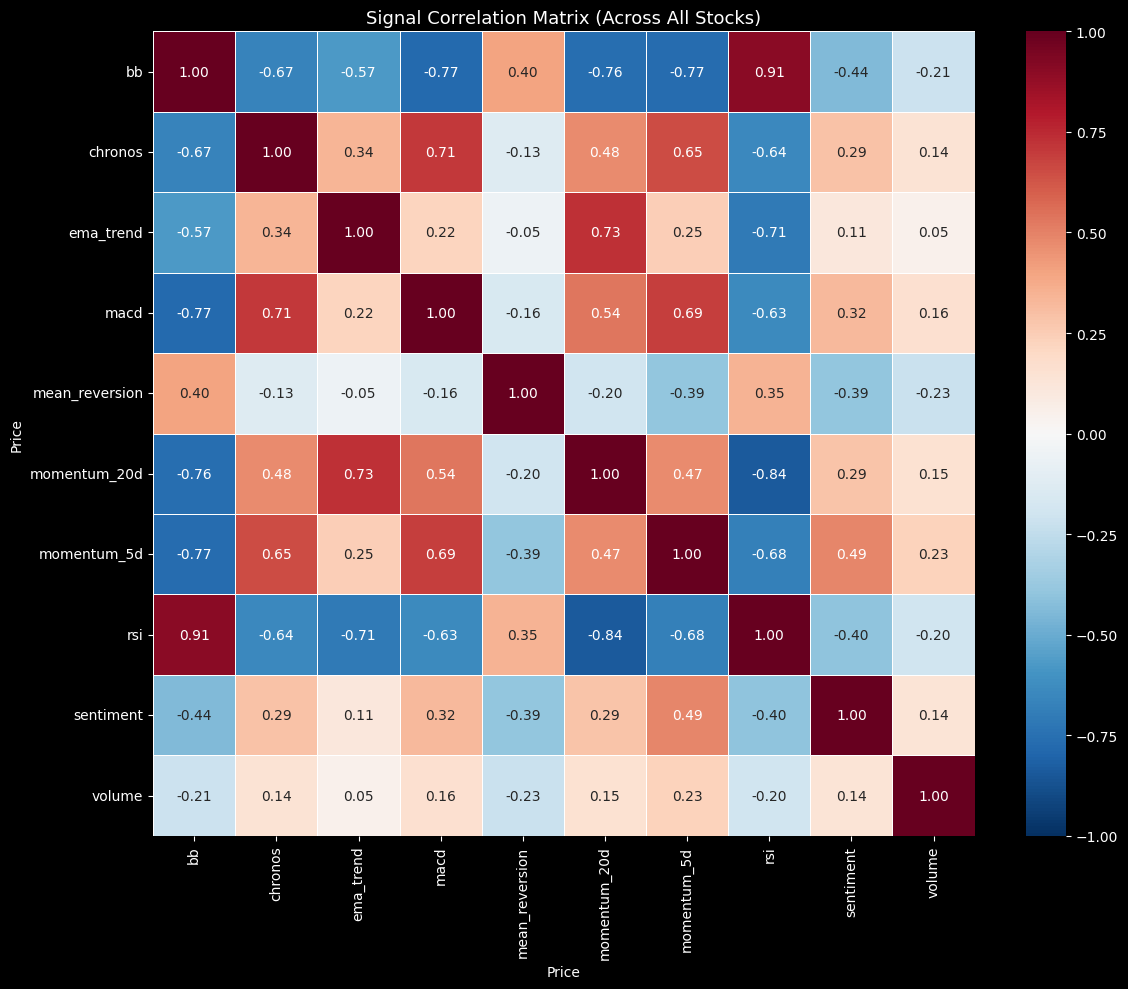

Highly Correlated Pairs (|r| > 0.5):
  sig_bb                    <-> sig_chronos               r = -0.666
  sig_bb                    <-> sig_ema_trend             r = -0.572
  sig_bb                    <-> sig_macd                  r = -0.774
  sig_bb                    <-> sig_momentum_20d          r = -0.758
  sig_bb                    <-> sig_momentum_5d           r = -0.766
  sig_bb                    <-> sig_rsi                   r = +0.906
  sig_chronos               <-> sig_macd                  r = +0.707
  sig_chronos               <-> sig_momentum_5d           r = +0.654
  sig_chronos               <-> sig_rsi                   r = -0.644
  sig_ema_trend             <-> sig_momentum_20d          r = +0.729
  sig_ema_trend             <-> sig_rsi                   r = -0.706
  sig_macd                  <-> sig_momentum_20d          r = +0.537
  sig_macd                  <-> sig_momentum_5d           r = +0.691
  sig_macd                  <-> sig_rsi                   r = -0.6

In [14]:
# Signal correlation matrix
sig_cols = sorted([c for c in composite_data['NVDA'].columns if c.startswith('sig_')])

# Stack all stocks for a more robust correlation estimate
all_signals = pd.concat([
    composite_data[t][sig_cols] for t in UNIVERSE
], ignore_index=True)

corr_matrix = all_signals.corr()

fig, ax = plt.subplots(figsize=(12, 10))
labels = [c.replace('sig_', '') for c in sig_cols]
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            xticklabels=labels, yticklabels=labels, ax=ax, linewidths=0.5,
            vmin=-1, vmax=1)
ax.set_title('Signal Correlation Matrix (Across All Stocks)', fontsize=13)
plt.tight_layout()
plt.show()

# Find highly correlated pairs
print("Highly Correlated Pairs (|r| > 0.5):")
for i in range(len(sig_cols)):
    for j in range(i+1, len(sig_cols)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.5:
            print(f"  {sig_cols[i]:<25} <-> {sig_cols[j]:<25} r = {r:+.3f}")

print("\nHighly correlated signals are partially redundant.")
print("Low correlation between sources = better diversification of signals.")

In [15]:
# Signal attribution: how much does each signal predict next-day returns?
print("Signal Predictive Power (correlation with next-day return):\n")

attribution_results = []
for ticker in UNIVERSE:
    df = composite_data[ticker].copy()
    df['next_return'] = df['Close'].pct_change().shift(-1)
    
    for col in sig_cols:
        corr = df[col].corr(df['next_return'])
        attribution_results.append({
            'signal': col.replace('sig_', ''),
            'ticker': ticker,
            'correlation': corr,
        })

attr_df = pd.DataFrame(attribution_results)
avg_attr = attr_df.groupby('signal')['correlation'].agg(['mean', 'std']).round(4)
avg_attr = avg_attr.sort_values('mean', ascending=False)

print(f"{'Signal':<25} {'Avg Corr':>10} {'Std':>10} {'Consistent?':>12}")
print("-" * 60)
for signal, row in avg_attr.iterrows():
    consistent = 'Yes' if abs(row['mean']) > row['std'] else 'No'
    print(f"{signal:<25} {row['mean']:>+10.4f} {row['std']:>10.4f} {consistent:>12}")

print("\nPositive correlation = signal correctly predicts direction.")
print("Consistent = signal effect is stable across stocks (good).")
print("\nNote: Even small positive correlations (0.01-0.05) can be profitable")
print("when combined with proper risk management and multiple signals.")

Signal Predictive Power (correlation with next-day return):

Signal                      Avg Corr        Std  Consistent?
------------------------------------------------------------
sentiment                    +0.0585     0.0322          Yes
rsi                          +0.0361     0.0408           No
chronos                      +0.0269     0.0450           No
bb                           +0.0244     0.0391           No
mean_reversion               +0.0209     0.0401           No
ema_trend                    -0.0192     0.0466           No
momentum_20d                 -0.0346     0.0339          Yes
momentum_5d                  -0.0350     0.0413           No
macd                         -0.0376     0.0410           No
volume                       -0.0618     0.0802           No

Positive correlation = signal correctly predicts direction.
Consistent = signal effect is stable across stocks (good).

Note: Even small positive correlations (0.01-0.05) can be profitable
when combined wit

---
## 7. Monte Carlo Simulation

Stress-test the strategy by randomly resampling trades.
This shows the range of outcomes you might expect.

Running 1,000 Monte Carlo simulations...



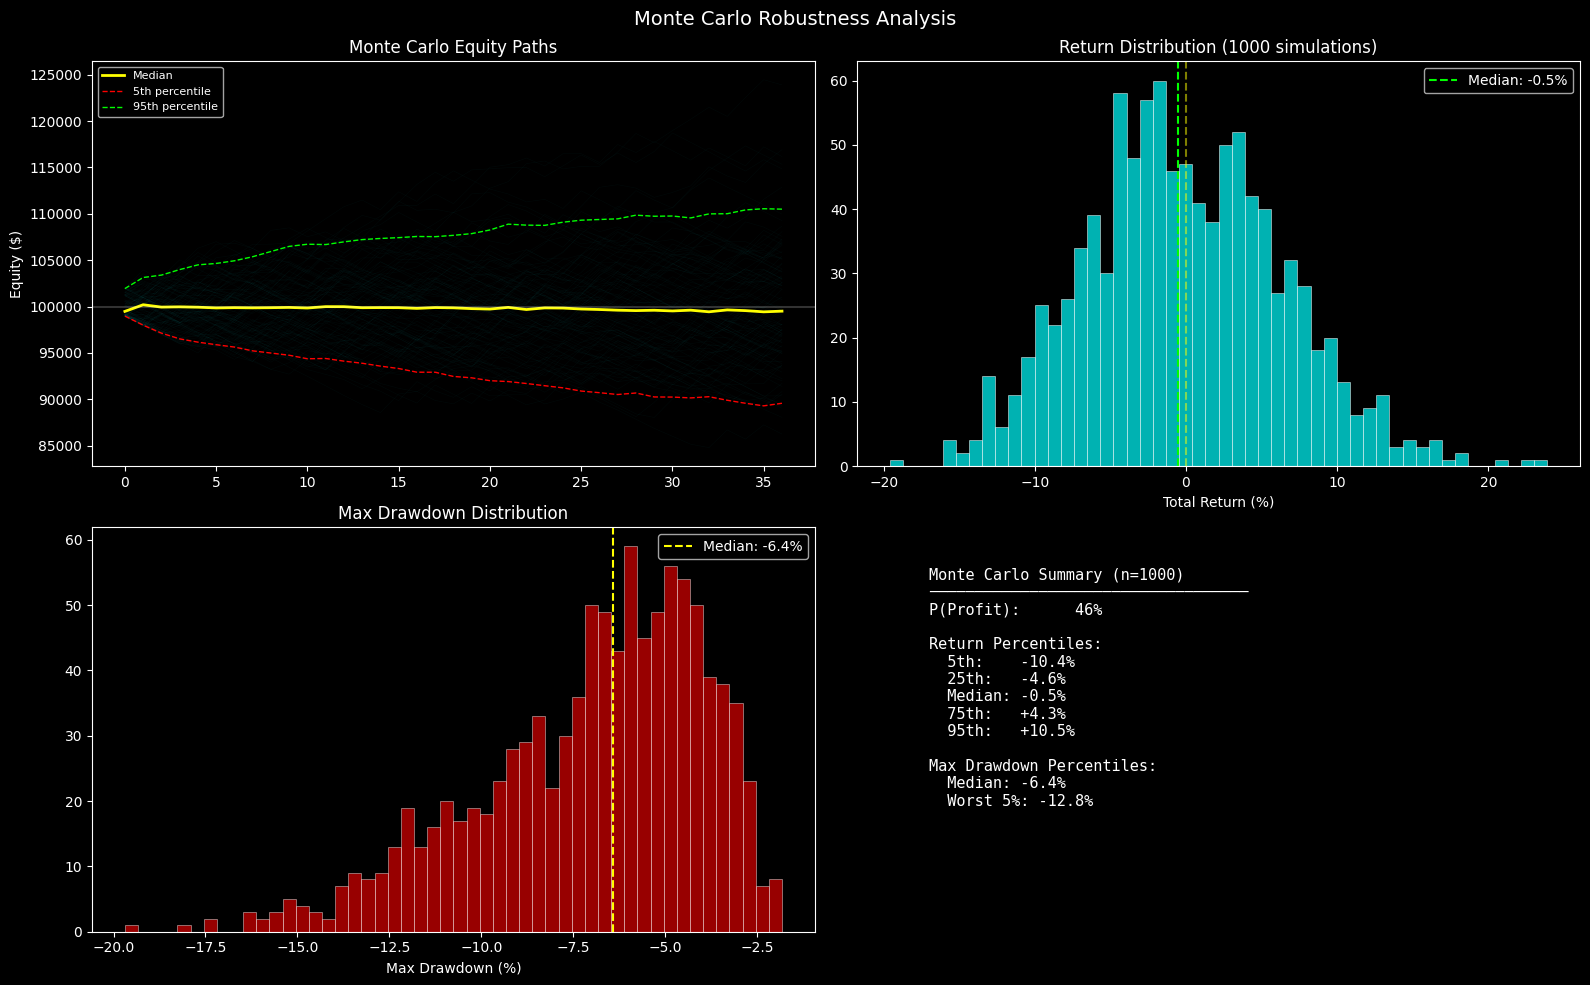

Probability of profit: 46%
Expected return: -0.5% (median)
Worst case (5th pctile): -10.4%
Best case (95th pctile): +10.5%


In [16]:
def monte_carlo_simulation(trades, initial_capital=100000, n_simulations=1000, n_trades=None):
    """
    Bootstrap Monte Carlo: resample from actual trades to simulate
    alternative histories.
    """
    if not trades:
        return None
    
    pnls = np.array([t.pnl for t in trades])
    if n_trades is None:
        n_trades = len(pnls)
    
    results = []
    for _ in range(n_simulations):
        # Randomly sample trades with replacement
        sampled_pnls = np.random.choice(pnls, size=n_trades, replace=True)
        equity = initial_capital + np.cumsum(sampled_pnls)
        
        # Calculate metrics
        total_return = (equity[-1] / initial_capital - 1) * 100
        peak = np.maximum.accumulate(np.concatenate([[initial_capital], equity]))
        dd = (np.concatenate([[initial_capital], equity]) - peak) / peak
        max_dd = dd.min() * 100
        
        results.append({
            'final_equity': equity[-1],
            'total_return': total_return,
            'max_drawdown': max_dd,
            'equity_curve': equity,
        })
    
    return results


# Run Monte Carlo
print("Running 1,000 Monte Carlo simulations...\n")
mc_results = monte_carlo_simulation(results['trades'], n_simulations=1000)

if mc_results:
    returns = [r['total_return'] for r in mc_results]
    drawdowns = [r['max_drawdown'] for r in mc_results]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Equity curve fan
    ax1 = axes[0, 0]
    for r in mc_results[:100]:  # Plot 100 paths
        ax1.plot(r['equity_curve'], alpha=0.03, color='cyan', linewidth=0.5)
    median_equity = np.median([r['equity_curve'] for r in mc_results], axis=0)
    p5 = np.percentile([r['equity_curve'] for r in mc_results], 5, axis=0)
    p95 = np.percentile([r['equity_curve'] for r in mc_results], 95, axis=0)
    ax1.plot(median_equity, color='yellow', linewidth=2, label='Median')
    ax1.plot(p5, color='red', linestyle='--', linewidth=1, label='5th percentile')
    ax1.plot(p95, color='lime', linestyle='--', linewidth=1, label='95th percentile')
    ax1.axhline(y=100000, color='white', alpha=0.2)
    ax1.set_title('Monte Carlo Equity Paths')
    ax1.set_ylabel('Equity ($)')
    ax1.legend(fontsize=8)
    
    # Return distribution
    ax2 = axes[0, 1]
    ax2.hist(returns, bins=50, color='cyan', alpha=0.7, edgecolor='white', linewidth=0.5)
    ax2.axvline(x=0, color='yellow', linestyle='--', alpha=0.5)
    ax2.axvline(x=np.median(returns), color='lime', linestyle='--', label=f'Median: {np.median(returns):+.1f}%')
    ax2.set_title('Return Distribution (1000 simulations)')
    ax2.set_xlabel('Total Return (%)')
    ax2.legend()
    
    # Drawdown distribution
    ax3 = axes[1, 0]
    ax3.hist(drawdowns, bins=50, color='red', alpha=0.6, edgecolor='white', linewidth=0.5)
    ax3.axvline(x=np.median(drawdowns), color='yellow', linestyle='--', label=f'Median: {np.median(drawdowns):.1f}%')
    ax3.set_title('Max Drawdown Distribution')
    ax3.set_xlabel('Max Drawdown (%)')
    ax3.legend()
    
    # Summary stats
    ax4 = axes[1, 1]
    ax4.axis('off')
    prob_profit = sum(1 for r in returns if r > 0) / len(returns) * 100
    summary = (
        f"Monte Carlo Summary (n=1000)\n"
        f"{'─'*35}\n"
        f"P(Profit):      {prob_profit:.0f}%\n\n"
        f"Return Percentiles:\n"
        f"  5th:    {np.percentile(returns, 5):+.1f}%\n"
        f"  25th:   {np.percentile(returns, 25):+.1f}%\n"
        f"  Median: {np.median(returns):+.1f}%\n"
        f"  75th:   {np.percentile(returns, 75):+.1f}%\n"
        f"  95th:   {np.percentile(returns, 95):+.1f}%\n\n"
        f"Max Drawdown Percentiles:\n"
        f"  Median: {np.median(drawdowns):.1f}%\n"
        f"  Worst 5%: {np.percentile(drawdowns, 5):.1f}%\n"
    )
    ax4.text(0.1, 0.9, summary, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace', color='white')
    
    plt.suptitle('Monte Carlo Robustness Analysis', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"Probability of profit: {prob_profit:.0f}%")
    print(f"Expected return: {np.median(returns):+.1f}% (median)")
    print(f"Worst case (5th pctile): {np.percentile(returns, 5):+.1f}%")
    print(f"Best case (95th pctile): {np.percentile(returns, 95):+.1f}%")

---
## 8. Walk-Forward Validation

The ultimate test: does this system work on unseen data?

In [17]:
def walk_forward_portfolio(all_raw_data, tickers, train_days=252, test_days=63, step_days=63):
    """
    Walk-forward analysis for the full portfolio system.
    """
    # Use the longest common date range
    common_dates = None
    for ticker in tickers:
        dates = set(all_raw_data[ticker].index)
        common_dates = dates if common_dates is None else common_dates & dates
    common_dates = sorted(common_dates)
    total_days = len(common_dates)
    
    window_results = []
    start = 0
    
    while start + train_days + test_days <= total_days:
        test_start = start + train_days
        test_end = test_start + test_days
        
        test_start_date = common_dates[test_start]
        test_end_date = common_dates[min(test_end, total_days) - 1]
        
        # Build signals using train+test data (indicators need history)
        # But only evaluate on test period
        composite_test = {}
        for ticker in tickers:
            raw = all_raw_data[ticker]
            subset = raw[(raw.index >= common_dates[start]) & (raw.index <= test_end_date)]
            if len(subset) < train_days + 10:
                continue
            
            full_signals = build_signal_matrix(subset)
            full_signals = RegimeDetector.classify(full_signals)
            full_signals = compute_composite_score(full_signals)
            
            # Only keep test period
            oos = full_signals[full_signals.index >= test_start_date]
            if len(oos) > 5:
                composite_test[ticker] = oos
        
        if len(composite_test) < 3:
            start += step_days
            continue
        
        # Run backtest on test period
        bt = PortfolioBacktester(initial_capital=100000, max_positions=5)
        result = bt.run(composite_test)
        m = result['metrics']
        
        window_results.append({
            'test_start': test_start_date.strftime('%Y-%m-%d'),
            'test_end': test_end_date.strftime('%Y-%m-%d'),
            'trades': m.get('total_trades', 0),
            'return_pct': m.get('total_return_pct', 0),
            'sharpe': m.get('sharpe_ratio', 0),
            'win_rate': m.get('win_rate', 0),
            'max_dd': m.get('max_drawdown_pct', 0),
            'profit_factor': m.get('profit_factor', 0),
        })
        
        start += step_days
    
    return pd.DataFrame(window_results)


# Run walk-forward
print("Running walk-forward analysis on full portfolio system...\n")
wf_df = walk_forward_portfolio(all_data, UNIVERSE, train_days=200, test_days=60, step_days=60)

if len(wf_df) > 0:
    print("Out-of-Sample Results by Window:\n")
    print(wf_df.round(2).to_string(index=False))
    
    profitable = (wf_df['return_pct'] > 0).sum()
    total = len(wf_df)
    print(f"\n--- Walk-Forward Summary ---")
    print(f"  Windows: {total}")
    print(f"  Profitable: {profitable}/{total} ({profitable/total*100:.0f}%)")
    print(f"  Avg OOS Return: {wf_df['return_pct'].mean():+.2f}%")
    print(f"  Avg OOS Sharpe: {wf_df['sharpe'].mean():.2f}")
    print(f"  Avg OOS Max DD: {wf_df['max_dd'].mean():.1f}%")
else:
    print("Not enough data for walk-forward with these window sizes.")

Running walk-forward analysis on full portfolio system...

Out-of-Sample Results by Window:

test_start   test_end  trades  return_pct  sharpe  win_rate  max_dd  profit_factor
2024-11-29 2025-02-27       5       -2.28   -0.93     40.00   -4.74           0.06
2025-02-28 2025-05-23       2       -0.43   -2.05      0.00   -0.43           0.00
2025-05-27 2025-08-20      11        6.36    2.38     54.55   -2.56           2.50
2025-08-21 2025-11-13       6        0.48    0.30     50.00   -2.52           1.27
2025-11-14 2026-02-11       5       -3.63   -3.80      0.00   -3.82           0.00

--- Walk-Forward Summary ---
  Windows: 5
  Profitable: 2/5 (40%)
  Avg OOS Return: +0.10%
  Avg OOS Sharpe: -0.82
  Avg OOS Max DD: -2.8%


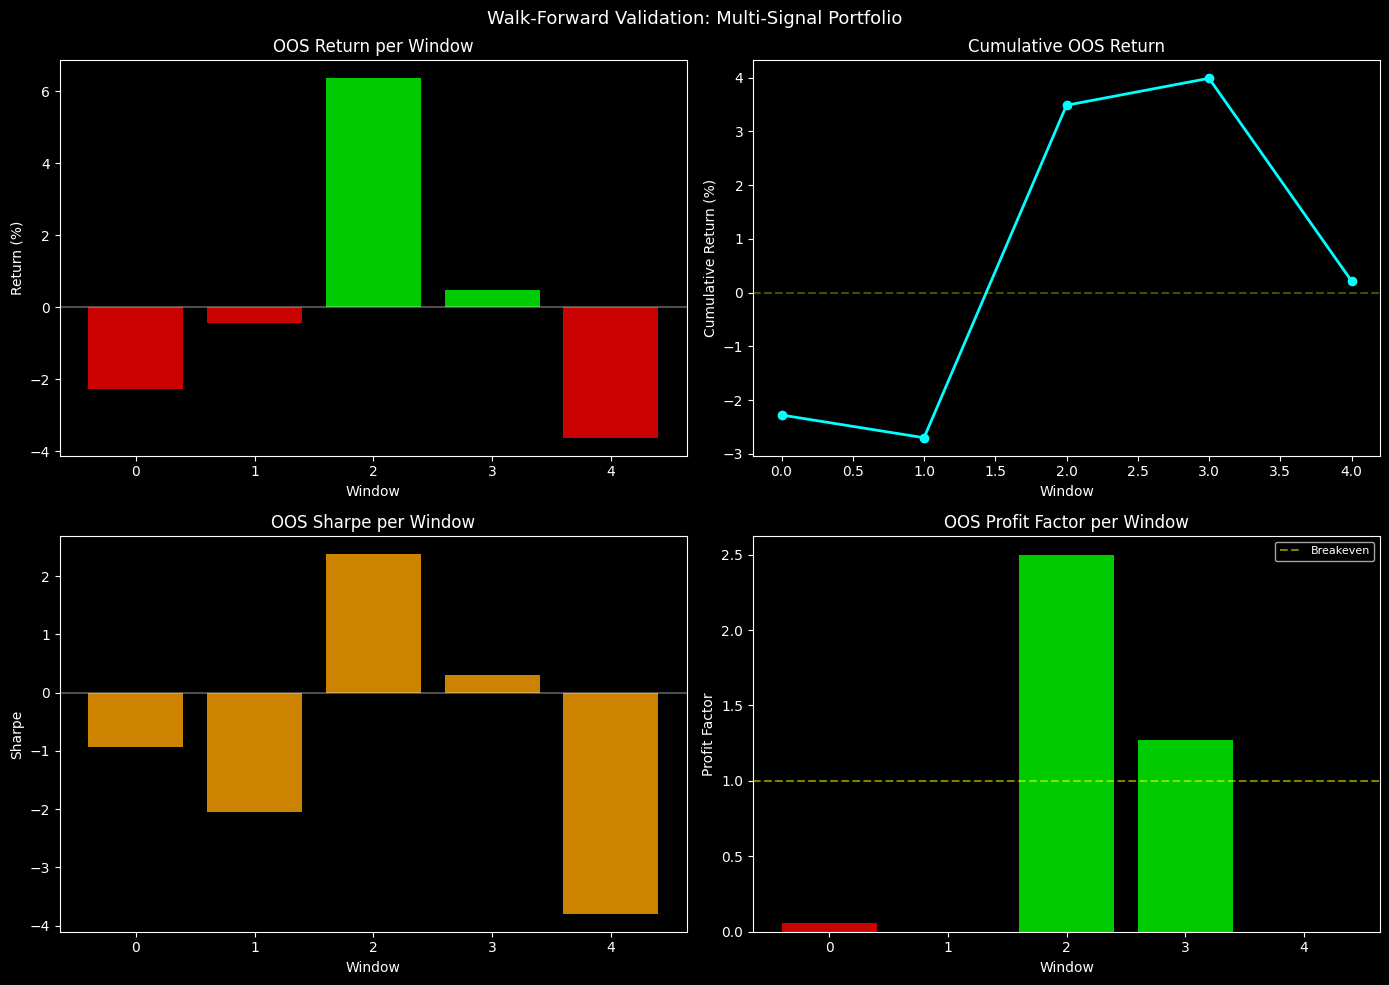

In [18]:
# Visualize walk-forward results
if len(wf_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Return per window
    colors = ['lime' if r > 0 else 'red' for r in wf_df['return_pct']]
    axes[0, 0].bar(range(len(wf_df)), wf_df['return_pct'], color=colors, alpha=0.8)
    axes[0, 0].axhline(y=0, color='white', alpha=0.3)
    axes[0, 0].set_title('OOS Return per Window')
    axes[0, 0].set_xlabel('Window')
    axes[0, 0].set_ylabel('Return (%)')
    
    # Cumulative return
    cum_ret = (1 + wf_df['return_pct']/100).cumprod() * 100 - 100
    axes[0, 1].plot(range(len(cum_ret)), cum_ret, color='cyan', marker='o', linewidth=2)
    axes[0, 1].axhline(y=0, color='yellow', linestyle='--', alpha=0.3)
    axes[0, 1].set_title('Cumulative OOS Return')
    axes[0, 1].set_xlabel('Window')
    axes[0, 1].set_ylabel('Cumulative Return (%)')
    
    # Sharpe
    axes[1, 0].bar(range(len(wf_df)), wf_df['sharpe'], color='orange', alpha=0.8)
    axes[1, 0].axhline(y=0, color='white', alpha=0.3)
    axes[1, 0].set_title('OOS Sharpe per Window')
    axes[1, 0].set_xlabel('Window')
    axes[1, 0].set_ylabel('Sharpe')
    
    # Profit Factor
    pf = wf_df['profit_factor'].clip(0, 5)  # cap for display
    pf_colors = ['lime' if p > 1 else 'red' for p in pf]
    axes[1, 1].bar(range(len(pf)), pf, color=pf_colors, alpha=0.8)
    axes[1, 1].axhline(y=1, color='yellow', linestyle='--', alpha=0.5, label='Breakeven')
    axes[1, 1].set_title('OOS Profit Factor per Window')
    axes[1, 1].set_xlabel('Window')
    axes[1, 1].set_ylabel('Profit Factor')
    axes[1, 1].legend(fontsize=8)
    
    plt.suptitle('Walk-Forward Validation: Multi-Signal Portfolio', fontsize=13)
    plt.tight_layout()
    plt.show()

---
## 9. Parameter Sensitivity & Optimization

How sensitive is the portfolio system to key parameters?

Running parameter sensitivity sweep...



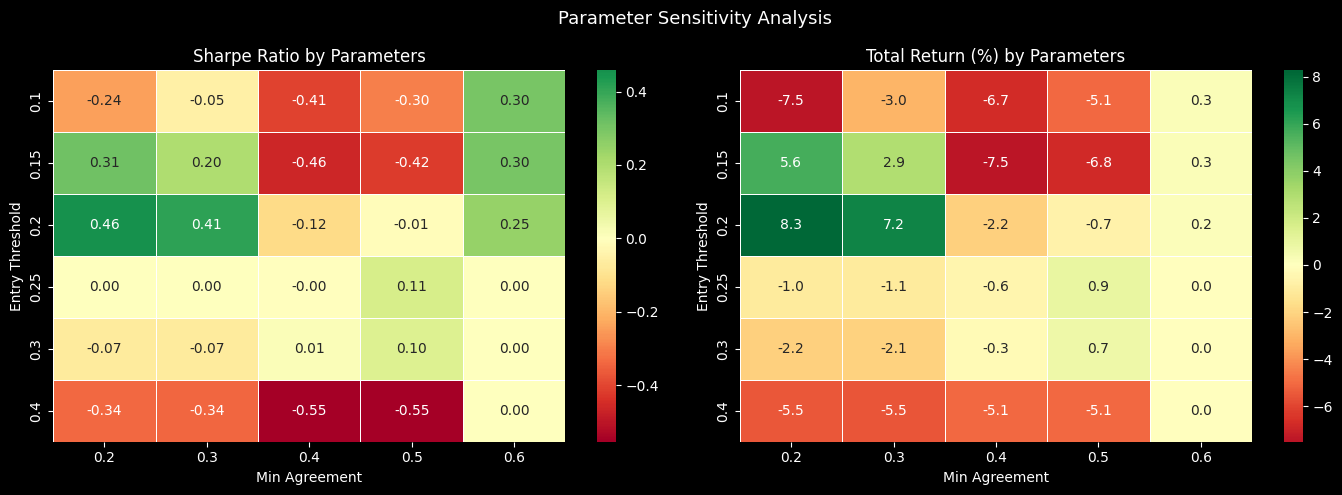

Profitable configurations: 9/30 (30%)
Best Sharpe config: Entry=0.2, Agreement=0.2
  -> Sharpe: 0.46, Return: +8.3%, Trades: 100


In [19]:
# Sweep entry threshold and agreement threshold
entry_thresholds = [0.10, 0.15, 0.20, 0.25, 0.30, 0.40]
agreement_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

param_results = []

print("Running parameter sensitivity sweep...\n")
for entry_t in entry_thresholds:
    for agree_t in agreement_thresholds:
        bt = PortfolioBacktester(
            initial_capital=100000,
            entry_threshold=entry_t,
            min_agreement=agree_t,
        )
        result = bt.run(composite_data)
        m = result['metrics']
        param_results.append({
            'Entry Threshold': entry_t,
            'Min Agreement': agree_t,
            'Trades': m.get('total_trades', 0),
            'Return %': m.get('total_return_pct', 0),
            'Sharpe': m.get('sharpe_ratio', 0),
            'Max DD %': m.get('max_drawdown_pct', 0),
            'Win Rate': m.get('win_rate', 0),
        })

param_sweep = pd.DataFrame(param_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sharpe heatmap
pivot_sharpe = param_sweep.pivot(index='Entry Threshold', columns='Min Agreement', values='Sharpe')
sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            ax=axes[0], linewidths=0.5)
axes[0].set_title('Sharpe Ratio by Parameters')

# Return heatmap
pivot_ret = param_sweep.pivot(index='Entry Threshold', columns='Min Agreement', values='Return %')
sns.heatmap(pivot_ret, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            ax=axes[1], linewidths=0.5)
axes[1].set_title('Total Return (%) by Parameters')

plt.suptitle('Parameter Sensitivity Analysis', fontsize=13)
plt.tight_layout()
plt.show()

positive = (param_sweep['Return %'] > 0).sum()
total = len(param_sweep)
print(f"Profitable configurations: {positive}/{total} ({positive/total*100:.0f}%)")
best = param_sweep.sort_values('Sharpe', ascending=False).iloc[0]
print(f"Best Sharpe config: Entry={best['Entry Threshold']}, Agreement={best['Min Agreement']}")
print(f"  -> Sharpe: {best['Sharpe']:.2f}, Return: {best['Return %']:+.1f}%, Trades: {int(best['Trades'])}")

---
## 10. Summary & Architecture

### What We Built

| Component | Purpose |
|-----------|--------|
| **TechnicalSignals** | EMA, RSI, MACD, BB -> normalized -1 to +1 signals |
| **MomentumSignals** | Multi-horizon momentum + volume + mean reversion |
| **SyntheticSentimentSignals** | Simulated sentiment & Chronos (replace with live data) |
| **RegimeDetector** | ADX-based trend/range/volatile classification |
| **Composite Score** | Regime-adaptive weighted average of all 10 signals |
| **PortfolioBacktester** | Multi-stock simultaneous trading with capital management |
| **Signal Correlation** | Identify redundant vs complementary signals |
| **Signal Attribution** | Measure each signal's predictive power |
| **Monte Carlo** | Bootstrap stress testing with probability of profit |
| **Walk-Forward** | Out-of-sample validation across rolling windows |
| **Parameter Sensitivity** | Robustness across parameter ranges |

### Key Lessons

1. **Combining signals beats any single signal** -- diversification of information sources
2. **Regime adaptation matters** -- trend-following fails in ranging markets and vice versa
3. **Signal agreement is a confidence filter** -- high agreement = higher conviction
4. **Monte Carlo reveals the range of possible outcomes** -- not just the backtest result
5. **Walk-forward is the only honest validation** -- single backtests overstate performance
6. **Robustness > optimization** -- the best config is one that works across many settings

### Production Integration

To use this live, replace the synthetic signals with:
- **`sig_sentiment`**: Real-time output from Notebook 02's FinBERT pipeline
- **`sig_chronos`**: Live Chronos forecasts from Notebook 04
- Add LLM signals from Notebook 05 as an additional signal category

### Coming Up Next

**Notebook 07: Paper Trading Bot** -- Connect to the Alpaca API to paper trade
this combined system in real-time.

In [20]:
!nvidia-smi

Sat Feb 14 09:49:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:04:00.0 Off |                  Off |
|  0%   35C    P8             15W /  450W |      20MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----